# How to use decision trees in practice

In this notebook, we illustrate how to use tree-based models to gain insight and make predictions. 

To demonstrate regression trees we predict returns, and for the classification case, we return to the example of positive and negative asset price moves.

In [116]:
%matplotlib inline

import warnings
import os
from pathlib import Path
import quandl
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import seaborn as sns
import graphviz
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, _tree
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, KFold
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, precision_recall_curve,  accuracy_score
from sklearn.preprocessing import Imputer
import statsmodels.api as sm
from scipy.interpolate import interp1d, interp2d

In [117]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

## Get Data

We use a simplified version of the data set constructed in Chapter 4, Alpha factor research. It consists of daily stock prices provided by Quandl for the 2010-2017 period and various engineered features. The details can be found in the notebook [data_prep](00_data_prep.ipynb) in the GitHub repo for this chapter.

The decision tree models in this chapter are not equipped to handle missing or categorical variables, so we will apply dummy encoding to the latter after dropping any of the former.

In [118]:
with pd.HDFStore('data.h5') as store:
    data = store['data']
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 171162 entries, (A, 2011-03-31 00:00:00) to (ZUMZ, 2018-02-28 00:00:00)
Data columns (total 61 columns):
returns                  171162 non-null float64
t-1                      171162 non-null float64
t-2                      171162 non-null float64
t-3                      171162 non-null float64
t-4                      171162 non-null float64
t-5                      171162 non-null float64
t-6                      171162 non-null float64
t-7                      171162 non-null float64
t-8                      171162 non-null float64
t-9                      171162 non-null float64
t-10                     171162 non-null float64
t-11                     171162 non-null float64
t-12                     171162 non-null float64
year_2011                171162 non-null uint8
year_2012                171162 non-null uint8
year_2013                171162 non-null uint8
year_2014                171162 non-null uint8
year_2015           

### Stock Prices

In [119]:
y = data.returns
X = data.drop('returns', axis=1)

### Binary Outcome

In [120]:
y_binary = (y>0).astype(int)

### 2 Lags Only

In [121]:
X2 = X.loc[:, ['t-1', 't-2']]
X2.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 171162 entries, (A, 2011-03-31 00:00:00) to (ZUMZ, 2018-02-28 00:00:00)
Data columns (total 2 columns):
t-1    171162 non-null float64
t-2    171162 non-null float64
dtypes: float64(2)
memory usage: 3.2+ MB


## Explore Data

In [122]:
y.describe(percentiles=np.arange(.1, .91, .1).round(1))

count    171162.000000
mean          0.009827
std           0.068340
min          -0.152427
10%          -0.080626
20%          -0.048064
30.0%        -0.025061
40%          -0.006481
50%           0.009259
60%           0.025641
70%           0.043847
80%           0.066246
90%           0.100111
max           0.185083
Name: returns, dtype: float64

<a id="custom_kfold"></a>
## Custom KFold

We also construct a custom cross-validation class tailored to the format of the data just created, which has pandas MultiIndex with two levels, one for the ticker and one for the data.

`OneStepTimeSeriesSplit` ensures a split of training and validation sets that avoids a lookahead bias by training models using only data up to period T-1 for each stock when validating using data for month T. We will only use one-step-ahead forecasts.

In [123]:
class OneStepTimeSeriesSplit:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the index contains a level labeled 'date'"""

    def __init__(self, n_splits=3, test_period_length=1, shuffle=False):
        self.n_splits = n_splits
        self.test_period_length = test_period_length
        self.shuffle = shuffle
        self.test_end = n_splits * test_period_length

    @staticmethod
    def chunks(l, chunk_size):
        for i in range(0, len(l), chunk_size):
            yield l[i:i + chunk_size]

    def split(self, X, y=None, groups=None):
        unique_dates = (X.index
                        .get_level_values('date')
                        .unique()
                        .sort_values(ascending=False)[:self.test_end])

        dates = X.reset_index()[['date']]
        for test_date in self.chunks(unique_dates, self.test_period_length):
            train_idx = dates[dates.date < min(test_date)].index
            test_idx = dates[dates.date.isin(test_date)].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [124]:
def regression_benchmark():
    rmse = []
    for train_idx, test_idx in cv.split(X):
        mean = y.iloc[train_idx].mean()
        data = y.iloc[test_idx].to_frame('y_test').assign(y_pred=mean)
        rmse.append(np.sqrt(mean_squared_error(data.y_test, data.y_pred))) 
    return np.mean(rmse)

In [125]:
def classification_benchmark():
    auc = []
    for train_idx, test_idx in cv.split(X):
        mean = y_binary.iloc[train_idx].mean()
        data = y_binary.iloc[test_idx].to_frame('y_test').assign(y_pred=mean)
        auc.append(roc_auc_score(data.y_test, data.y_pred))
    return np.mean(auc)

## Simple Regression Tree

Regression trees make predictions based on the mean outcome value for the training samples assigned to a given node and typically rely on the mean-squared error to select optimal rules during recursive binary splitting.

Given a training set, the algorithm iterates over the predictors, $X_1, X_2, ..., X_p$, and possible cutpoints, $s_1, s_2, ..., s_N$, to find an optimal combination. The optimal rule splits the feature space into two regions, $\{X\mid X_i < s_j\}$ and $\{X\mid X_i > s_j\}$, with values for the $X_i$ feature either below or above the $s_j$ threshold so that predictions based on the training subsets maximize the reduction of the squared residuals relative to the current node.

### Configure Tree

Let's start with a simplified example to facilitate visualization and only use two months of lagged returns to predict the following month, in the vein of an AR(2) model from the last chapter:

In [126]:
reg_tree_t2 = DecisionTreeRegressor(criterion='mse',
                                    splitter='best',
                                    max_depth=4,
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    min_weight_fraction_leaf=0.0,
                                    max_features=None,
                                    random_state=42,
                                    max_leaf_nodes=None,
                                    min_impurity_decrease=0.0,
                                    min_impurity_split=None,
                                    presort=False)

### Train Decision Tree

In [127]:
reg_tree_t2.fit(X=X2, y=y)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

### Visualize Tree

You can visualize the tree using the graphviz library (see GitHub for installation instructions) because sklearn can output a description of the tree using the .dot language used by that library. 

You can configure the output to include feature and class labels and limit the number of levels to keep the chart readable, as follows:

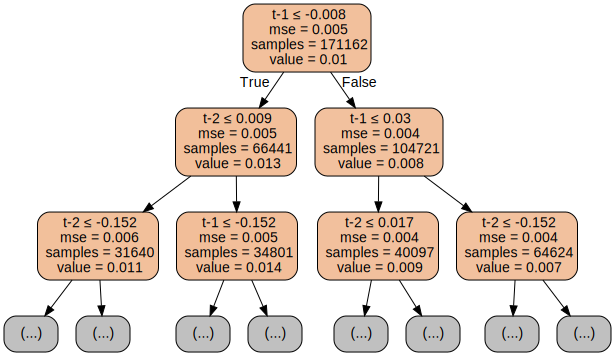

In [128]:
out_file = 'figures/reg_tree_t2.dot'
dot_data = export_graphviz(reg_tree_t2,
                          out_file=out_file,
                          feature_names=X2.columns,
                          max_depth=2,
                          filled=True,
                          rounded=True,
                          special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

### Compare with Linear Regression

The OLS summary below and a visualization of the first two levels of the decision tree above reveal the striking differences between the models. The OLS model provides three parameters for the intercepts and the two features in line with the linear assumption.

In contrast, the regression tree chart above displays for each node of the first two levels the feature and threshold used to split the data (note that features can be used repeatedly), as well as the current value of the mean-squared error (MSE), the number of samples, and predicted value based on these training samples.

The tree chart also highlights the uneven distribution of samples across the nodes as the numbers vary between 31,000 and 65,000 samples after only two splits.

#### statsmodels OLS

In [129]:
ols_model = sm.OLS(endog=y, exog=sm.add_constant(X2)).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     113.2
Date:                Fri, 19 Apr 2019   Prob (F-statistic):           7.64e-50
Time:                        20:38:49   Log-Likelihood:             2.1652e+05
No. Observations:              171162   AIC:                        -4.330e+05
Df Residuals:                  171159   BIC:                        -4.330e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0101      0.000     59.627      0.0

### Compare with Linear Time Series Models

#### statsmodels AR(2) Model

Coefficients slighty different because AR model treats returns as a single time series instead creating groups by ticker.

In [95]:
ar_model = sm.tsa.ARMA(endog=y, order=(2,0)).fit()

In [96]:
pd.DataFrame({'AR(2)': ar_model.params.values, 
              'OLS': ols_model.params.values}, 
             index=ols_model.params.index)

,AR(2),OLS
const,0.009827,0.010077
t-1,-0.035791,-0.034772
t-2,0.007291,0.009200


In [97]:
ar_preds = ar_model.predict()

#### ARMA(2,2)

In [24]:
arma_model = sm.tsa.ARMA(endog=y, order=(2, 2)).fit()
print(arma_model.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:               431221
Model:                     ARMA(2, 2)   Log Likelihood              310290.628
Method:                       css-mle   S.D. of innovations              0.118
Date:                Fri, 19 Apr 2019   AIC                        -620569.256
Time:                        01:09:52   BIC                        -620503.410
Sample:                             0   HQIC                       -620550.501
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0117      0.000     64.348      0.000       0.011       0.012
ar.L1.returns    -0.4107      0.073     -5.617      0.000      -0.554      -0.267
ar.L2.returns     0.5148      0.069     

In [25]:
arma_preds = arma_model.predict()

In [26]:
preds = X2.assign(arma=arma_preds, ar=ar_preds).sample(frac=.1).sort_values(['t-1', 't-2'])
preds.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 43122 entries, (PL, 2009-03-31 00:00:00) to (FTK, 2011-01-31 00:00:00)
Data columns (total 4 columns):
t-1     43122 non-null float64
t-2     43122 non-null float64
arma    43122 non-null float64
ar      43122 non-null float64
dtypes: float64(4)
memory usage: 1.5+ MB


In [27]:
q = 20
preds['t-1q'] = pd.qcut(preds['t-1'], q=q, labels=list(range(1, q+1))).astype(int)
preds['t-2q'] = pd.qcut(preds['t-2'], q=q, labels=list(range(1, q+1))).astype(int)

#### Decision Surfaces

The plot of the decision surface for both time series models illustrates how the ARMA model is capable of representing a more complex dynamic relationship.

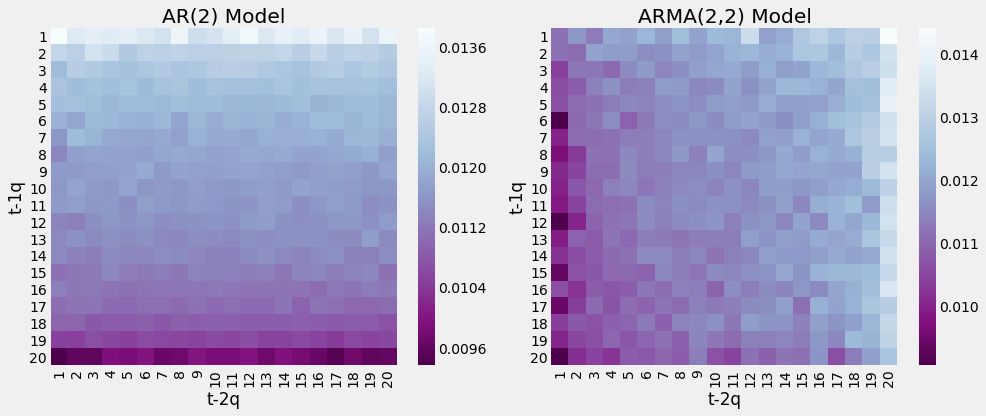

In [28]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
sns.heatmap(preds.groupby(['t-1q', 't-2q']).ar.median().unstack(), ax=axes[0], cmap='BuPu_r')
axes[0].set_title('AR(2) Model')
sns.heatmap(preds.groupby(['t-1q', 't-2q']).arma.median().unstack(), ax=axes[1], cmap='BuPu_r')
axes[1].set_title('ARMA(2,2) Model')
fig.tight_layout();

### sklearn Linear Regression

In [130]:
lin_reg = LinearRegression()

In [131]:
# %%timeit
lin_reg.fit(X=X2,y=y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [132]:
lin_reg.intercept_

0.010076949882654875

In [133]:
lin_reg.coef_

array([-0.0347715 ,  0.00920031])

### Linear Regression vs Regressin Tree Decision Surfaces

To further illustrate the different assumptions about the functional form of the relationships between the input variables and the output, we can visualize current return predictions as a function of the feature space, that is, as a function of the range of values for the lagged returns. The following figure shows the current period return as a function of returns one and two periods ago for linear regression and the regression tree:

The linear-regression model result on the right side underlines the linearity of the relationship between lagged and current returns, whereas the regression tree chart on the left illustrates the non-linear relationship encoded in the recursive partitioning of the feature space.

In [150]:
t1, t2 = np.meshgrid(np.linspace(X2['t-1'].quantile(.01), X2['t-1'].quantile(.99), 100),
                     np.linspace(X2['t-2'].quantile(.01), X2['t-2'].quantile(.99), 100))
X_data = np.c_[t1.ravel(), t2.ravel()]

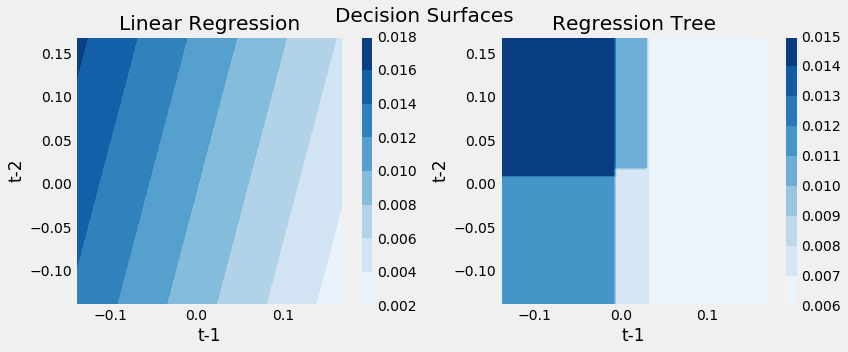

In [151]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5))

# Linear Regression
ret1 = lin_reg.predict(X_data).reshape(t1.shape)
surface1 = axes[0].contourf(t1, t2, ret1, cmap='Blues')
plt.colorbar(mappable=surface1, ax=axes[0])

# Regression Tree
ret2 = reg_tree_t2.predict(X_data).reshape(t1.shape)
surface2 = axes[1].contourf(t1, t2, ret2, cmap='Blues')
# surface2 = axes[1].contourf(t1, t2, np.clip(ret2, a_min=-.05, a_max=.05), cmap='Blues')
plt.colorbar(mappable=surface2, ax=axes[1])

# Format plots
titles = ['Linear Regression', 'Regression Tree']
for i, ax in enumerate(axes):
    ax.set_xlabel('t-1')
    ax.set_ylabel('t-2')
    ax.set_title(titles[i])

fig.suptitle('Decision Surfaces', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9);

## Simple Classification Tree

A classification tree works just like the regression version, except that categorical nature of the outcome requires a different approach to making predictions and measuring the loss. While a regression tree predicts the response for an observation assigned to a leaf node using the mean outcome of the associated training samples, a classification tree instead uses the mode, that is, the most common class among the training samples in the relevant region. A classification tree can also generate probabilistic predictions based on relative class frequencies.

### Loss Functions

When growing a classification tree, we also use recursive binary splitting but, instead of evaluating the quality of a decision rule using the reduction of the mean-squared error, we can use the classification error rate, which is simply the fraction of the training samples in a given (leave) node that do not belong to the most common class.

However, the alternative measures, Gini Index or Cross-Entropy, are preferred because they are more sensitive to node purity than the classification error rate. Node purity refers to the extent of the preponderance of a single class in a node. A node that only contains samples with outcomes belonging to a single class is pure and imply successful classification for this particular region of the feature space. 

In [49]:
def entropy(f):
    return (-f*np.log2(f) - (1-f)*np.log2(1-f))/2

In [50]:
def gini(f):
    return 2*f*(1-f)

In [51]:
def misclassification_rate(f):
    return np.where(f<=.5, f, 1-f)

Both the Gini Impurity and the Cross-Entropy measure take on smaller values when the class proportions approach zero or one, that is, when the child nodes become pure as a result of the split and are highest when the class proportions are even or 0.5 in the binary case. 

The chart below visualizes the values assumed by these two measures and the misclassification error rates across the [0, 1] interval of proportions.

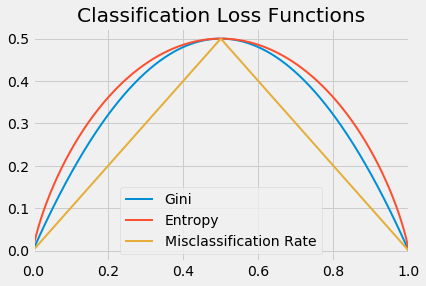

In [52]:
x = np.linspace(0, 1, 10000)
(pd.DataFrame({'Gini': gini(x), 
              'Entropy': entropy(x),
             'Misclassification Rate': misclassification_rate(x)}, index=x)
 .plot(title='Classification Loss Functions', lw=2));

#### Compare computation time

Gini is often preferred over entropy because it computes faster:

In [53]:
%%timeit
misclassification_rate(x)

14.5 µs ± 458 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [42]:
%%timeit
gini(x)

11.4 µs ± 458 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [43]:
%%timeit
entropy(x)

211 µs ± 11.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Configure Tree

In [152]:
clf_tree_t2 = DecisionTreeClassifier(criterion='gini',
                                     splitter='best',
                                     max_depth=4,
                                     min_samples_split=2,
                                     min_samples_leaf=1,
                                     min_weight_fraction_leaf=0.0,
                                     max_features=None,
                                     random_state=42,
                                     max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     class_weight=None,
                                     presort=False)

### Train Tree

In [153]:
# %%timeit
clf_tree_t2.fit(X=X2, y=y_binary)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

### Visualize Tree

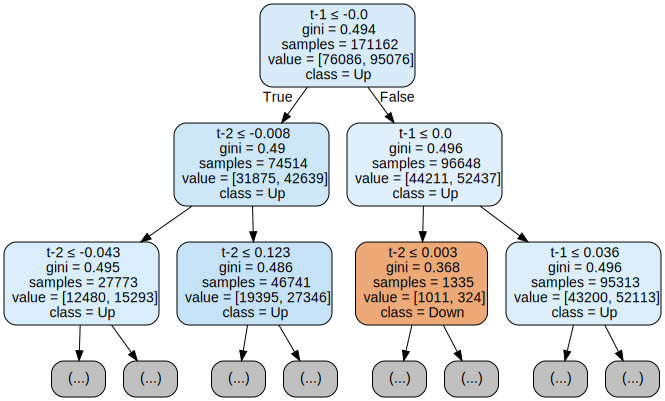

In [56]:
out_file = 'figures/clf_tree_t2.dot'
dot_data = export_graphviz(clf_tree_t2,
                           out_file=out_file,
                           feature_names=X2.columns,
                           class_names=['Down', 'Up'],
                           max_depth=2,
                           filled=True,
                           rounded=True,
                           special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

### Compare with Logistic Regression

#### Statsmodels

In [57]:
model = sm.Logit(endog=y_binary, exog=sm.add_constant(X2)).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.686503
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                returns   No. Observations:               171162
Model:                          Logit   Df Residuals:                   171159
Method:                           MLE   Df Model:                            2
Date:                Fri, 19 Apr 2019   Pseudo R-squ.:               0.0006944
Time:                        01:41:26   Log-Likelihood:            -1.1750e+05
converged:                       True   LL-Null:                   -1.1758e+05
                                        LLR p-value:                 3.478e-36
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2246      0.005     45.067      0.000       0.215       0.234
t-1           -0.7208      0.

#### sklearn

In [58]:
logistic_reg = LogisticRegression()

In [59]:
# %%timeit
logistic_reg.fit(X=X2, y=y_binary)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [60]:
logistic_reg.coef_

array([[-0.71721119,  0.52531984]])

### Plot Decision Surfaces

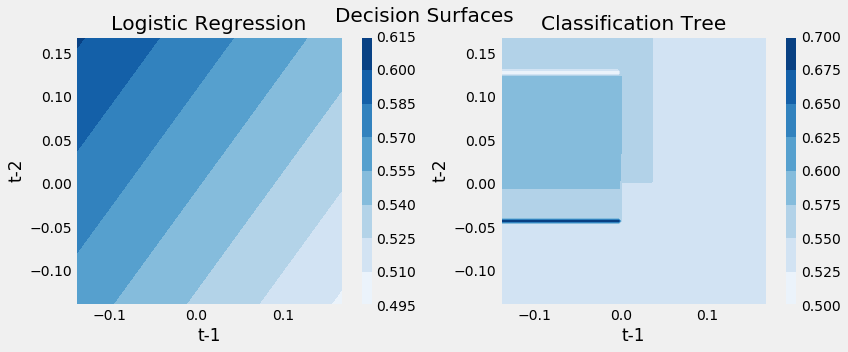

In [154]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5))

# Linear Regression
ret1 = logistic_reg.predict_proba(X_data)[:, 1].reshape(t1.shape)
surface1 = axes[0].contourf(t1, t2, ret1, cmap='Blues')
plt.colorbar(mappable=surface1, ax=axes[0])

# Regression Tree
ret2 = clf_tree_t2.predict_proba(X_data)[:, 1].reshape(t1.shape)
surface2 = axes[1].contourf(t1, t2, ret2, cmap='Blues')
plt.colorbar(mappable=surface2, ax=axes[1])

# Format plots
titles = ['Logistic Regression', 'Classification Tree']
for i, ax in enumerate(axes):
    ax.set_xlabel('t-1')
    ax.set_ylabel('t-2')
    ax.set_title(titles[i])

fig.suptitle('Decision Surfaces', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9);

## Regression Tree with all Features

We now train, visualize, and evaluate a regression tree with up to 5 consecutive splits using 80% of the samples for training to predict the remaining 20%.

We are taking a shortcut here to simplify the illustration and use the built-in train_test_split, which does not protect against lookahead bias, as our custom iterator. The tree configuration implies up to $2^5=32$ leaf nodes that, on average in the balanced case, would contain over 4,300 of the training samples.

### Train-Test Split

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Configure Tree

The output after training the model displays all the DecisionTreeClassifier parameters that we will address in more detail in the next section when we discuss parameter-tuning. 

In [64]:
regression_tree = DecisionTreeRegressor(criterion='mse',
                                        splitter='best',
                                        max_depth=5,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0.0,
                                        max_features=None,
                                        random_state=42,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        presort=False)

### Train Model

In [65]:
regression_tree.fit(X=X_train, y=y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

### Visualize Tree

The result shows that the model uses a variety of different features and indicates the split rules for both continuous and categorical (dummy) variables. 

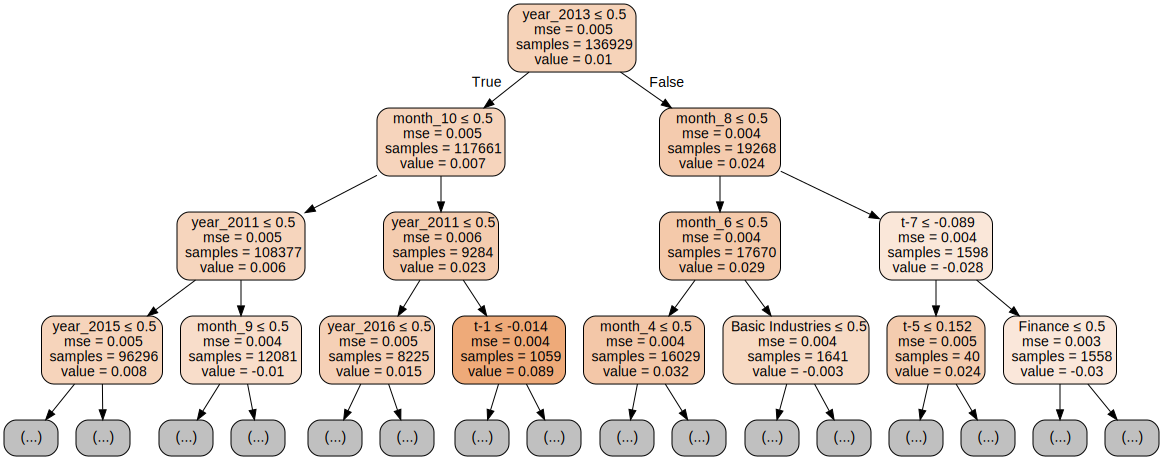

In [66]:
out_file = 'figures/reg_tree.dot'
dot_data = export_graphviz(regression_tree,
                           out_file=out_file,
                           feature_names=X_train.columns,
                           max_depth=3,
                           filled=True,
                           rounded=True,
                           special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

### Evaluate Test Set

In [67]:
y_pred = regression_tree.predict(X_test)

In [68]:
np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))

0.06600785966046621

## Classification Tree with all Features

We will now train, visualize, and evaluate a classification tree with up to 5 consecutive splits using 80% of the samples for training to predict the remaining 20%. We are taking a shortcut here to simplify the illustration and use the built-in train_test_split, which does not protect against lookahead bias, as our custom iterator. The tree configuration implies up to $2^5=32$ leaf nodes that, on average in the balanced case, would contain over 4,300 of the training samples.

### Train-Test Split

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

In [70]:
clf = DecisionTreeClassifier(criterion='gini',
                             max_depth=5,
                             random_state=42)

In [71]:
clf.fit(X=X_train, y=y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

To evaluate the predictive accuracy of our first classification tree, we will use our test set to generate predicted class probabilities. 

The `.predict_proba()` method produces one probability for each class. In the binary class, these probabilities are complementary and sum to 1, so we only need the value for the positive class. 

In [72]:
y_score = clf.predict_proba(X=X_test)[:, 1]

To evaluate the generalization error, we will use the area under the curve based on the receiver-operating characteristic that we introduced in Chapter 6, The Machine Learning Process. The result indicates a significant improvement above and beyond the baseline value of 0.5 for a random prediction:

In [73]:
roc_auc_score(y_score=y_score, y_true=y_test)

0.6139767794050386

### Plot Tree

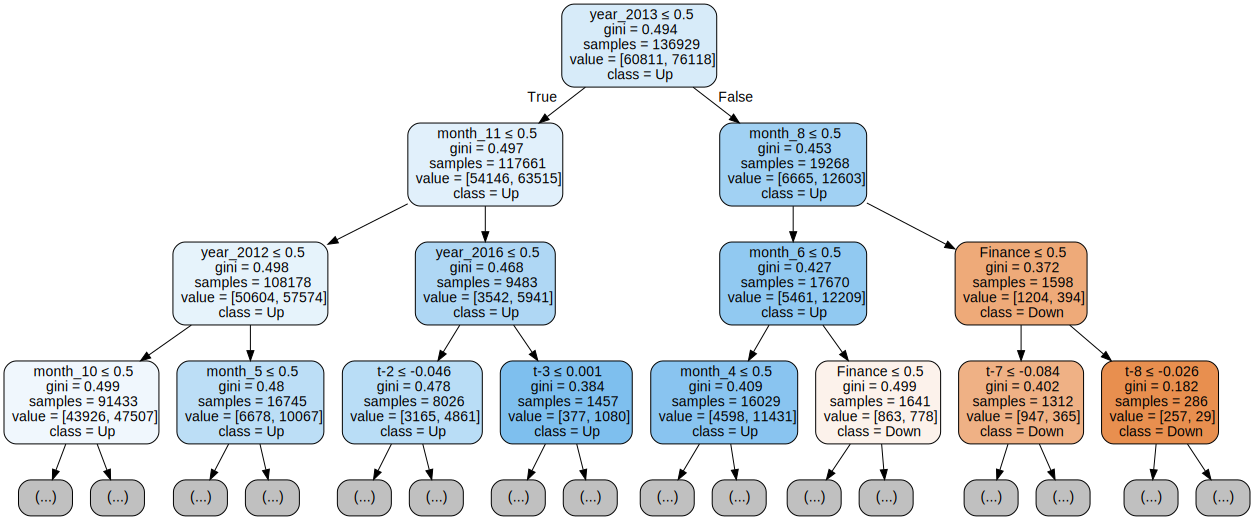

In [74]:
out_file = 'figures/clf_tree.dot'
dot_data = export_graphviz(clf,
                           out_file=out_file,
                           feature_names=X.columns,
                           class_names=['Down', 'Up'],
                           max_depth=3,
                           filled=True,
                           rounded=True,
                           special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

### Evaluate Test Set

In [77]:
y_pred = clf.predict_proba(X_test)[:, 1]

In [78]:
roc_auc_score(y_true=y_test, y_score=y_pred)

0.6139767794050386

### Print Decision Path

Inspired by https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree

In [79]:
from sklearn.tree._tree import Tree
help(Tree)

Help on class Tree in module sklearn.tree._tree:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The maximal depth of the tree.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child of node i.
 |      For leaves,

In [80]:
def tree_to_code(tree, feature_names):
    if isinstance(tree, DecisionTreeClassifier):
        model = 'clf'
    elif isinstance(tree, DecisionTreeRegressor):
        model = 'reg'
    else:
        raise ValueError('Need Regression or Classification Tree')
        
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print(indent, f'if {name} <= {threshold:.2%}')
            recurse(tree_.children_left[node], depth + 1)
            print(indent, f'else:  # if {name} > {threshold:.2%}')
            recurse(tree_.children_right[node], depth + 1)
        else:
            pred = tree_.value[node][0]
            val = pred[1]/sum(pred) if model == 'clf' else pred[0]
            print(indent, f'return {val:.2%}')
    recurse(0, 1)

In [82]:
tree_to_code(clf_tree_t2, X2.columns)

def tree(t-1, t-2):
   if t-1 <= -0.01%
     if t-2 <= -0.80%
       if t-2 <= -4.34%
         if t-1 <= -0.06%
           return 54.06%
         else:  # if t-1 > -0.06%
           return 76.60%
       else:  # if t-2 > -4.34%
         if t-2 <= -4.27%
           return 68.55%
         else:  # if t-2 > -4.27%
           return 56.10%
     else:  # if t-2 > -0.80%
       if t-2 <= 12.29%
         if t-2 <= 3.49%
           return 57.98%
         else:  # if t-2 > 3.49%
           return 59.71%
       else:  # if t-2 > 12.29%
         if t-2 <= 12.98%
           return 50.12%
         else:  # if t-2 > 12.98%
           return 55.72%
   else:  # if t-1 > -0.01%
     if t-1 <= 0.00%
       if t-2 <= 0.29%
         if t-2 <= -0.46%
           return 45.24%
         else:  # if t-2 > -0.46%
           return 3.21%
       else:  # if t-2 > 0.29%
         if t-2 <= 8.22%
           return 43.55%
         else:  # if t-2 > 8.22%
           return 57.01%
     else:  # if t-1 > 0.00%
       if

## Overfitting, Regularization & Parameter Tuning

Decision trees have a strong tendency to overfit, especially when a dataset has a large number of features relative to the number of samples. As discussed in previous chapters, overfitting increases the prediction error because the model does not only learn the signal contained in the training data, but also the noise.
There are several ways to address the risk of overfitting.

Decision trees provide several regularization hyperparameters to limit the growth of a tree and the associated complexity. While every split increases the number of nodes, it also reduces the number of samples available per node to support a prediction. For each additional level, twice the number of samples is needed to populate the new nodes with the same sample density. 

### Decision Tree Parameters

The following table lists key parameters available for this purpose in the sklearn decision tree implementation. After introducing the most important parameters, we will illustrate how to use cross-validation to optimize the hyperparameter settings with respect to the bias-variance tradeoff and lower prediction errors:

| Parameter                | Default | Options                                                                                                                                                               | Description                                                                                                                                                                                                             |
|--------------------------|---------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| criterion                | gini    | Regression: MSE, MAE Classification: Gini impurity, Cross Entropy                                                                                                     | Metric to evaluate split quality.                                                                                                                                                                                       |
| splitter                 | best    | best, random                                                                                                                                                          | How to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.                                                                            |
| max_depth                | None    | int                                                                                                                                                                   | Max # of levels in tree. Split nodes until max_depth is reached or all leaves are pure or all leaves contain less than min_samples_split samples.                                                                       |
| max_features             | None    | None: max_features=n_features; int; float (fraction): int(max_features * n_features)  auto, sqrt: max_features=sqrt(n_features). log2: max_features=log2(n_features). | # of features to consider when evaluating split                                                                                                                                                                         |
| max_leaf_nodes           | None    | None: unlimited # of leaf nodes int                                                                                                                                   | Continue to split nodes that reduce relative impurity the most until reaching max_leaf_nodes.                                                                                                                           |
| min_impurity_decrease    | 0       | float                                                                                                                                                                 | Split node if impurity decreases by at least this value.                                                                                                                                                                |
| min_samples_leaf         | 1       | int; float (as percentage of N)                                                                                                                                       | Minimum # of samples to be at a leaf node. A split will only be considered if there are at least min_samples_leaf training samples in each of the left and right branches. May smoothen the model, esp. for regression. |
| min_samples_split        | 2       | int; float (as percentage of N)                                                                                                                                       | The minimum number of samples required to split an internal node:                                                                                                                                                       |
| min_weight_fraction_leaf | 0       | NA                                                                                                                                                                    | The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided (in fit method).                       |
| presort                  | False   | NA                                                                                                                                                                    | Sort the data to speed up the search for best splits during training. Can slow down training on 'large' datasets but may speed up training on small data or with small max_depth setting.                               |
| class_weight             | None    | balanced: inversely proportional to class frequencies dict: {class_label: weight} list of dicts (for multi-output)                                                    | Weights associated with classes                                                                                                                                                                                         |

The `max_depth` parameter imposes a hard limit on the number of consecutive splits and represents the most straightforward way to cap the growth of a tree.

The m`in_samples_split` and `min_samples_leaf` parameters are alternative, data-driven ways to limit the growth of a tree. Rather than imposing a hard limit on the number of consecutive splits, these parameters control the minimum number of samples required to further split the data. The latter guarantees a certain number of samples per leaf, while the former can create very small leaves if a split results in a very uneven distribution. Small parameter values facilitate overfitting, while a high number may prevent the tree from learning the signal in the data. 

The default values are often quite low, and you should use cross-validation to explore a range of potential values. You can also use a float to indicate a percentage as opposed to an absolute number. 

In [83]:
def plot_cv_results(cv_scores, metric='AUC', parameter='Max. Depth'):
    fig, ax = plt.subplots(figsize=(12,6))
    df = pd.DataFrame(cv_scores)
    sns.tsplot(df.values, time=df.columns, ax=ax, lw=2)
    ax.set_title(f'{len(df)}-Fold Cross-Validation Result')
    ax.set_xlabel(parameter)
    ax.set_ylabel(metric)
    if metric == 'AUC':
        ax.axvline(df.mean().idxmax(), ls='--', c='k', lw=1);
        ax.axhline(classification_benchmark(), c='red', lw=1, ls='--') 
    else:
        ax.axvline(df.mean().idxmin(), ls='--', c='k', lw=1);
        ax.axhline(regression_benchmark(), c='red', lw=1, ls='--')

### Cross-Validation Score

Cross-validation is the most important tool to obtain an unbiased estimate of the generalization error, which in turn permits an informed choice among the various configuration options. sklearn offers several tools to facilitate the process of cross-validating numerous parameter settings, namely the GridSearchCV convenience class that we will illustrate in the next section. 

In [84]:
cv = OneStepTimeSeriesSplit(n_splits=10)

In [85]:
clf_results = {}
for max_depth in range(1, 26):
    clf_tree = DecisionTreeClassifier(criterion='gini',
                                      max_depth=max_depth,
                                      min_samples_leaf=5,
                                      random_state=42)
    clf_results[max_depth] = cross_val_score(clf_tree,
                                             X=X,
                                             y=y_binary,
                                             scoring='roc_auc',
                                             n_jobs=-1,
                                             cv=cv)

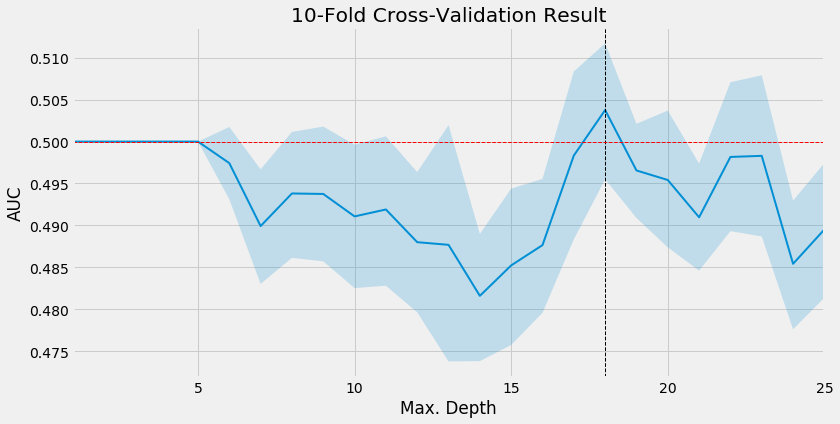

In [86]:
plot_cv_results(clf_results)

### Train-Test Result

In [87]:
max_depths = range(1, 26)

#### How to inspect the tree structure

The following code illustrates how to run cross-validation more manually to obtain custom tree attributes, such as the total number of nodes or leaf nodes associated with certain hyperparameter settings. 

The following function accesses the internal `.tree_` attribute to retrieve information about the total node count, and how many of these nodes are leaf nodes:

In [88]:
def get_leaves_count(tree):
    t = tree.tree_
    n = t.node_count
    leaves = len([i for i in range(t.node_count) if t.children_left[i]== -1])
    return leaves

We can combine this information with the train and test scores to gain detailed knowledge about the model behavior throughout the cross-validation process, as follows:

In [89]:
train_scores, val_scores, leaves = {}, {}, {}
for max_depth in max_depths:
    print(max_depth, end=' ', flush=True)
    clf = DecisionTreeClassifier(criterion='gini', 
                                 max_depth=max_depth,
                                 min_samples_leaf=500,
                                 max_features='auto',
                                 random_state=42)
    train_scores[max_depth], val_scores[max_depth], leaves[max_depth] = [], [], []
    for train_idx, test_idx in cv.split(X):
        X_train, y_train,  = X.iloc[train_idx], y_binary.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y_binary.iloc[test_idx]
        clf.fit(X=X_train, y=y_train)

        train_pred = clf.predict_proba(X=X_train)[:, 1]
        train_score = roc_auc_score(y_score=train_pred, y_true=y_train)
        train_scores[max_depth].append(train_score)

        test_pred = clf.predict_proba(X=X_test)[:, 1]
        val_score = roc_auc_score(y_score=test_pred, y_true=y_test)
        val_scores[max_depth].append(val_score)    
        leaves[max_depth].append(get_leaves_count(clf))
        
clf_train_scores = pd.DataFrame(train_scores)
clf_valid_scores = pd.DataFrame(val_scores)
clf_leaves = pd.DataFrame(leaves)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

## Regression Tree

### Cross-Validation Scores

In [90]:
reg_results = {}
for max_depth in range(1, 26):
    reg_tree = DecisionTreeRegressor(criterion='mse',
                                     max_depth=max_depth,
                                     min_samples_leaf=500,
                                     random_state=42)
    reg_results[max_depth] = np.sqrt(-cross_val_score(reg_tree,
                                             X=X,
                                             y=y,
                                             scoring='neg_mean_squared_error',
                                             n_jobs=-1,
                                             cv=cv))

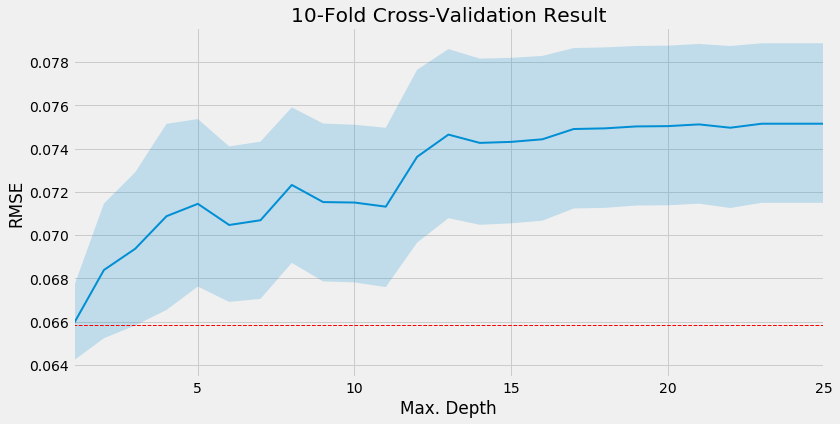

In [91]:
plot_cv_results(reg_results, metric='RMSE')

In [92]:
train_scores, val_scores, leaves = {}, {}, {}
for max_depth in max_depths:
    print(max_depth, end=' ', flush=True)
    reg_tree = DecisionTreeRegressor(max_depth=max_depth,
                                     min_samples_leaf=500,
                                     max_features= 'sqrt',
                                     random_state=42)
    train_scores[max_depth], val_scores[max_depth], leaves[max_depth] = [], [], []
    for train_idx, test_idx in cv.split(X):
        X_train, y_train,  = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        reg_tree.fit(X=X_train, y=y_train)

        train_pred = reg_tree.predict(X=X_train)
        train_score = np.sqrt(mean_squared_error(
            y_pred=train_pred, y_true=y_train))
        train_scores[max_depth].append(train_score)

        test_pred = reg_tree.predict(X=X_test)
        val_score = np.sqrt(mean_squared_error(
            y_pred=test_pred, y_true=y_test))
        val_scores[max_depth].append(val_score)
        leaves[max_depth].append(get_leaves_count(reg_tree))

reg_train_scores = pd.DataFrame(train_scores)
reg_valid_scores = pd.DataFrame(val_scores)
reg_leaves = pd.DataFrame(leaves)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

#### Plot Results

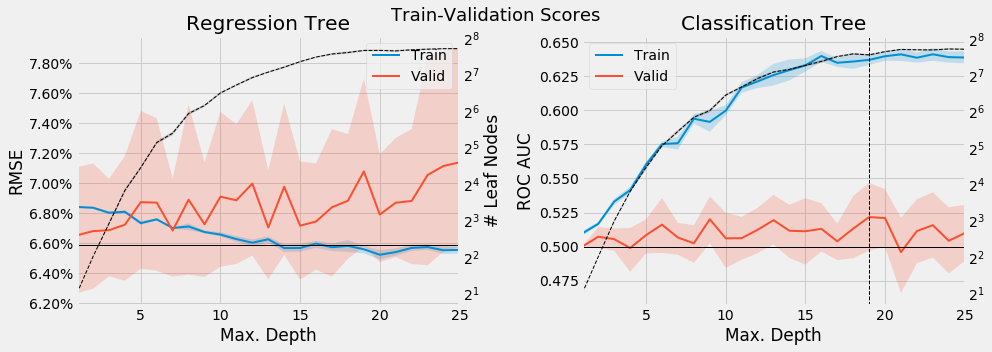

In [93]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
time = pd.Series(max_depths, name='Max. Depth')
sns.tsplot(data=np.dstack((reg_train_scores, reg_valid_scores)),
           time=time,
           condition=['Train', 'Valid'],
           ci=95,
           ax=axes[0],
           lw=2)
ax0 = axes[0].twinx()
sns.tsplot(data=reg_leaves.values, time=time, ax=ax0, ls='--', lw=1, color='k')
ax0.set_yscale('log', basey=2)
ax0.grid(None)
ax0.set_ylabel('# Leaf Nodes')
axes[0].set_title('Regression Tree')
axes[0].set_ylabel('RMSE')
axes[0].yaxis.set_major_formatter(
    FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
axes[0].axvline(x=reg_valid_scores.mean().idxmin(), ls='--', c='k', lw=1)
axes[0].axhline(y=regression_benchmark(), ls='-', c='k', lw=1)


sns.tsplot(data=np.dstack((clf_train_scores, clf_valid_scores)),
           time=pd.Series(max_depths, name='Max. Depth'),
           condition=['Train', 'Valid'],
           ci=95,
           ax=axes[1],
           lw=2)
ax1 = axes[1].twinx()
sns.tsplot(data=clf_leaves.values, time=time, ax=ax1, ls='--', lw=1, color='k')
ax1.set_yscale('log', basey=2)
ax1.grid(None)
axes[1].set_title('Classification Tree')
axes[1].set_ylabel('ROC AUC')
axes[1].axvline(x=clf_valid_scores.mean().idxmax(), ls='--', c='k', lw=1)
axes[1].axhline(y=classification_benchmark(), ls='-', c='k', lw=1)

fig.suptitle(f'Train-Validation Scores', fontsize=18)
fig.tight_layout()
fig.subplots_adjust(top=.9)

### GridSearch

sklearn provides a method to define ranges of values for multiple hyperparameters. It automates the process of cross-validating the various combinations of these parameter values to identify the optimal configuration. Let's walk through the process of automatically tuning your model.

#### Classification Tree

In [94]:
OneStepTimeSeriesSplit

__main__.OneStepTimeSeriesSplit

The first step is to instantiate a model object and define a dictionary where the keywords name the hyperparameters, and the values list the parameter settings to be tested:

In [95]:
clf = DecisionTreeClassifier(random_state=42)
param_grid = {'max_depth': range(10, 20),
              'min_samples_leaf': [250, 500, 750],
              'max_features': ['sqrt', 'auto']
              }

Then, instantiate the GridSearchCV object, providing the estimator object and parameter grid, as well as a scoring method and cross-validation choice to the initialization method. We'll use an object of our custom OneStepTimeSeriesSplit class, initialized to use ten folds for the cv parameter, and set the scoring to the roc_auc metric. We can parallelize the search using the n_jobs parameter and automatically obtain a trained model that uses the optimal hyperparameters by setting `refit=True`.

In [96]:
gridsearch_clf = GridSearchCV(estimator=clf,
                          param_grid=param_grid,
                          scoring='roc_auc',
                          n_jobs=-1,
                          cv=cv,
                          refit=True,
                          return_train_score=True)

With all settings in place, we can fit GridSearchCV just like any other model:

In [97]:
gridsearch_clf.fit(X=X, y=y_binary)

GridSearchCV(cv=<__main__.OneStepTimeSeriesSplit object at 0x7fce013c9240>,
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': range(10, 20), 'min_samples_leaf': [250, 500, 750], 'max_features': ['sqrt', 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

The training process produces some new attributes for our GridSearchCV object, most importantly the information about the optimal settings and the best cross-validation score (now using the proper setup that avoids lookahead bias).

Setting `max_depth` to 16, `min_samples_leaf` to 750, and randomly selecting only a number corresponding to the square root of the total number of features when deciding on a split, produces the best results, with an AUC of 0.529:


In [98]:
gridsearch_clf.best_params_

{'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 750}

In [99]:
gridsearch_clf.best_score_

0.5287748989846169

#### Regression Tree

In [100]:
reg_tree = DecisionTreeRegressor(random_state=42)

param_grid = {'max_depth': [1,2],
              'min_samples_leaf': [10],
              'max_features': [None, 'sqrt']
              }

In [101]:
gridsearch_reg = GridSearchCV(estimator=reg_tree,
                              param_grid=param_grid,
                              scoring='neg_mean_squared_error',
                              n_jobs=-1,
                              cv=cv,
                              refit=True,
                              return_train_score=True)

In [102]:
gridsearch_reg.fit(X=X, y=y)

GridSearchCV(cv=<__main__.OneStepTimeSeriesSplit object at 0x7fce013c9240>,
       error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [1, 2], 'min_samples_leaf': [10], 'max_features': [None, 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [103]:
gridsearch_reg.best_params_

{'max_depth': 1, 'max_features': None, 'min_samples_leaf': 10}

In [104]:
np.sqrt(-gridsearch_reg.best_score_)

0.06595263400245509

In [105]:
regression_benchmark()

0.06583066067442996

### Learning Curves

A learning curve is a useful tool that displays how the validation and training score evolve as the number of training samples evolves.

The purpose of the learning curve is to find out whether and how much the model would benefit from using more data during training. It is also useful to diagnose whether the model's generalization error is more likely driven by bias or variance.

If, for example, both the validation score and the training score converge to a similarly low value despite an increasing training set size, the error is more likely due to bias, and additional training data is unlikely to help.

#### Classifier

In [106]:
sizes = np.arange(.1, 1.01, .1)

In [107]:
train_sizes, train_scores, valid_scores = learning_curve(gridsearch_clf.best_estimator_,
                                                          X,
                                                          y_binary,
                                                          train_sizes=sizes,
                                                          cv=cv,
                                                          scoring='roc_auc',
                                                          n_jobs=-1,
                                                          shuffle=True,
                                                          random_state=42)
clf_data = np.dstack((train_scores.T, valid_scores.T))

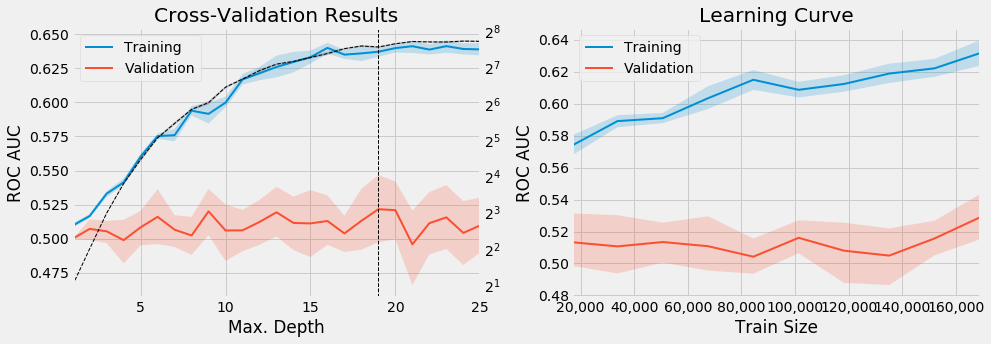

In [108]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
condition = ['Training', 'Validation']
sns.tsplot(data=np.dstack((clf_train_scores, clf_valid_scores)),
           time=pd.Series(max_depths, name='Max. Depth'),
           condition=condition,
           ci=95,
           ax=axes[0],
           lw=2)
ax1 = axes[0].twinx()
sns.tsplot(data=clf_leaves.values, time=time, ax=ax1, ls='--', lw=1, color='k')
ax1.set_yscale('log', basey=2)
ax1.grid(None)
axes[0].set_title('Cross-Validation Results')
axes[0].set_ylabel('ROC AUC')
axes[0].axvline(x=clf_valid_scores.mean().idxmax(), ls='--', c='k', lw=1)


sns.tsplot(data=clf_data, 
           time=pd.Series(train_sizes, name='Train Size'), 
           condition=condition, 
           ci=95, 
           ax=axes[1],
          lw=2)
axes[1].set_title('Learning Curve')
axes[1].set_ylabel('ROC AUC')
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))


# fig.suptitle(f'Train-Validation Scores', fontsize=18)
fig.tight_layout()
# fig.subplots_adjust(top=.9)

#### Regression Tree

In [109]:
train_sizes, train_scores, valid_scores = learning_curve(gridsearch_reg.best_estimator_,
                                                          X, y,
                                                          train_sizes=sizes,
                                                          cv=cv,
                                                          scoring='neg_mean_squared_error',
                                                          n_jobs=-1,
                                                          shuffle=True,
                                                          random_state=42)
reg_data = np.dstack((train_scores.T, valid_scores.T))

#### Plot Result

In [110]:
time = pd.Series(train_sizes, name='Train Size')

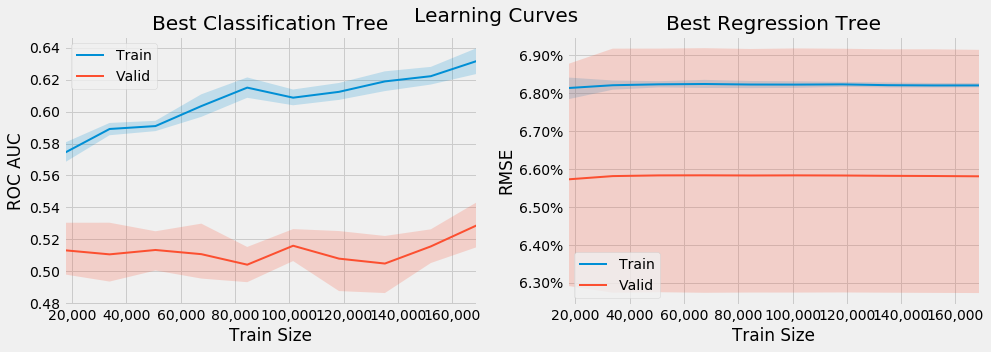

In [111]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
sns.tsplot(data=clf_data, 
           time=time, 
           condition=['Train', 'Valid'], 
           ci=95, 
           ax=axes[0],
          lw=2)
axes[0].set_title('Best Classification Tree')
axes[0].set_ylabel('ROC AUC')
axes[0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

sns.tsplot(data=np.sqrt(-reg_data), 
           time=time, 
           condition=['Train', 'Valid'], 
           ci=95, 
           ax=axes[1],
           lw=2)
axes[1].set_title('Best Regression Tree')
axes[1].set_ylabel('RMSE')
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
fig.suptitle('Learning Curves', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9);

### Feature Importance

Decision trees can not only be visualized to inspect the decision path for a given feature, but also provide a summary measure of the contribution of each feature to the model fit to the training data. 

The feature importance captures how much the splits produced by the feature helped to optimize the model's metric used to evaluate the split quality, which in our case is the Gini Impurity index. 

A feature's importance is computed as the (normalized) total reduction of this metric and takes into account the number of samples affected by a split. Hence, features used earlier in the tree where the nodes tend to contain more samples typically are considered of higher importance.

In [112]:
top_n = 15
labels = X.columns.str.replace('_', ' ').str.capitalize()
fi_clf = (pd.Series(gridsearch_clf.best_estimator_.feature_importances_, 
                    index=labels).sort_values(ascending=False).iloc[:top_n])
fi_reg = (pd.Series(gridsearch_reg.best_estimator_.feature_importances_, 
                    index=labels).sort_values(ascending=False).iloc[:top_n])

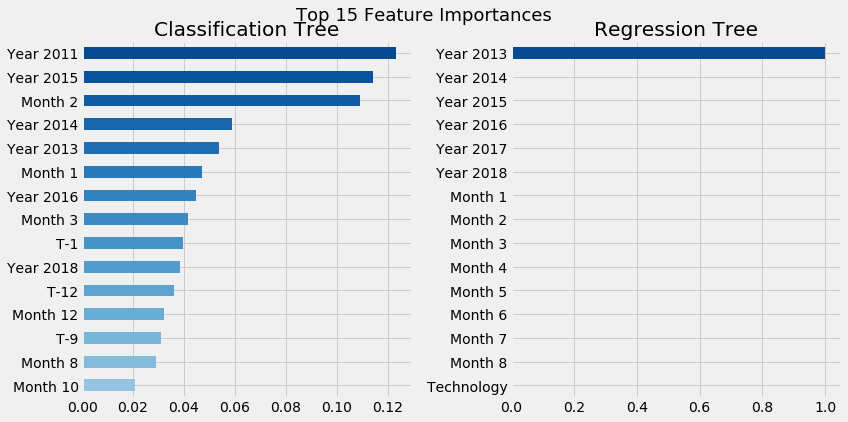

In [113]:
fig, axes= plt.subplots(ncols=2, figsize=(12,6))
color = cm.Blues(np.linspace(.4,.9, top_n))
fi_clf.sort_values().plot.barh(ax=axes[0], title='Classification Tree', color=color)
fi_reg.sort_values().plot.barh(ax=axes[1], title='Regression Tree', color=color)
fig.suptitle(f'Top {top_n} Feature Importances', fontsize=18)
fig.tight_layout()
fig.subplots_adjust(top=.9);

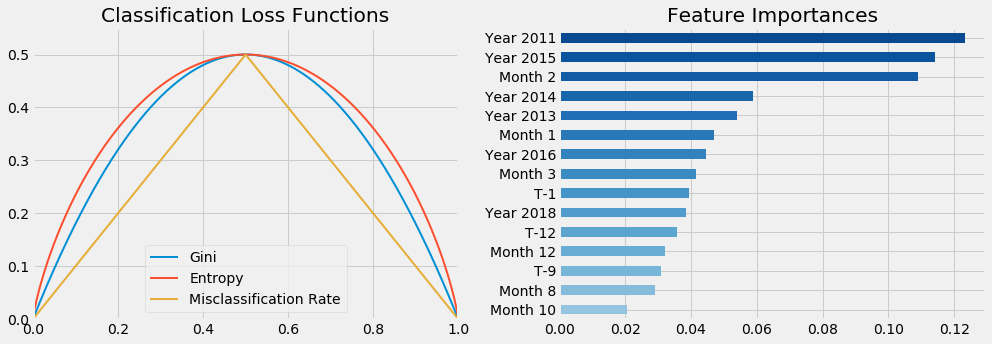

In [114]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
(pd.DataFrame({'Gini': gini(x), 
              'Entropy': entropy(x),
             'Misclassification Rate': misclassification_rate(x)}, index=x)
 .plot(title='Classification Loss Functions', lw=2, ax=axes[0], ylim=(0, .55)))

top_n = 15
labels = X.columns.str.replace('_', ' ').str.capitalize()
fi_clf = (pd.Series(gridsearch_clf.best_estimator_.feature_importances_, 
                    index=labels).sort_values(ascending=False).iloc[:top_n])
color = cm.Blues(np.linspace(.4,.9, top_n))
fi_clf.sort_values().plot.barh(ax=axes[1], title='Feature Importances', color=color)


# fig.suptitle('Best Classification Tree', fontsize=20)
fig.tight_layout()
# fig.subplots_adjust(top=.9);

In [115]:
dt = pd.DataFrame({'y': [1,2,3], 'x': [2, np.nan, 3]})
dt

,y,x
0,1,2.0
1,2,NaN
2,3,3.0
